In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowerdatasets/flowers/val/orchid/5479838376_b9ef4b2dd4_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/15317253397_c17cf35524_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/2068689248_2f31a3160b_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/15368996319_9f8354726f_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/8505987237_cf07748498_c.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/6467770439_cf417e8003_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/2452354536_2e0380c81e_c.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/6803947634_f0ed5fec65_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/6921280358_c7a94654e2_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/57715059_fc26450350_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/12241437214_05d3b7a7eb_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/2187054004_ca79f859e6_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/16806723606_297fa28edb_k.jpg
/kaggle/in

# import và setup

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("✅ Libraries imported.")

✅ Libraries imported.


# Path

In [2]:
BASE_DIR = "flowers"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

base_dir = Path(BASE_DIR)
train_dir = Path(TRAIN_DIR)
val_dir   = Path(VAL_DIR)
test_dir  = Path(TEST_DIR)

class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'lily', 'orchid', 'rose', 'sunflower', 'tulip']


# RootSIFT extractor

In [3]:
sift = cv2.SIFT_create()

def extract_rootsift_descriptors(img_gray, max_kp=500):
    """
    Trích xuất RootSIFT descriptors từ ảnh grayscale.
    img_gray: ảnh grayscale (ndarray)
    """
    keypoints, desc = sift.detectAndCompute(img_gray, None)
    if desc is None:
        return None

    if desc.shape[0] > max_kp:
        desc = desc[:max_kp]
        
    # ======= RootSIFT =======
    desc = desc.astype("float32")
    # 1) L1 normalize từng descriptor
    desc /= (desc.sum(axis=1, keepdims=True) + 1e-7)
    # 2) Căn bậc hai từng phần tử
    desc = np.sqrt(desc)

    return desc


# Thu thập SIFT descriptor từ train & train codebook (BoVW)

In [4]:
# ============================================
# Thu thập SIFT descriptors từ train
# ============================================

def collect_descriptors_from_train(train_folder, max_images_per_class=250):
    """
    Thu thập tất cả SIFT descriptors từ tập train để train codebook.
    """
    all_desc = []
    train_folder = Path(train_folder)

    for cls in class_names:
        cls_dir = train_folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        img_files = img_files[:max_images_per_class]
        print(f"[Collect] {cls}: {len(img_files)} images")
        
        for img_path in img_files:
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            img_gray = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2GRAY)
            desc = extract_rootsift_descriptors(img_gray)
            if desc is not None:
                all_desc.append(desc)

    if not all_desc:
        return None

    all_desc = np.vstack(all_desc)
    return all_desc


print("\n" + "="*50)
print("Collecting SIFT descriptors from training set...")
print("="*50)

all_desc = collect_descriptors_from_train(train_dir, max_images_per_class=250)
print("All descriptors shape:", all_desc.shape)


# ============================================
# Train Codebook (K-means)
# ============================================

K = 700  # Số "visual words"

print("\n" + "="*50)
print(f"Training MiniBatchKMeans with K={K} ...")
print("="*50)

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2000,
    n_init=10,
    random_state=42,
    verbose=1
)
kmeans.fit(all_desc)
print("✅ Codebook trained.")


# ============================================
# Trích BoVW cho 1 ảnh
# ============================================

def image_to_bovw(img_path):
    """
    Trả về feature vector = BoVW histogram từ RootSIFT.
    """
    img = cv2.imread(str(img_path))
    if img is None:
        # fallback vector zeros
        return np.zeros(K, dtype=np.float32)

    img_resized = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # --- BoVW từ RootSIFT ---
    desc = extract_rootsift_descriptors(gray)
    if desc is None:
        bovw_hist = np.zeros(K, dtype=np.float32)
    else:
        words = kmeans.predict(desc)
        bovw_hist, _ = np.histogram(words, bins=np.arange(K+1))
        bovw_hist = bovw_hist.astype("float32")
        # Hellinger normalization
        bovw_hist /= (bovw_hist.sum() + 1e-7)
        bovw_hist = np.sqrt(bovw_hist)

    return bovw_hist


[Collect] daisy: 250 images
[Collect] dandelion: 250 images
[Collect] lily: 250 images
[Collect] orchid: 250 images
[Collect] rose: 250 images
[Collect] sunflower: 250 images
[Collect] tulip: 250 images
All descriptors shape: (591596, 128)

Training MiniBatchKMeans with K=700 ...
Init 1/10 with method k-means++
Inertia for init 1/10: 1588.5970458984375
Init 2/10 with method k-means++
Inertia for init 2/10: 1587.8759765625
Init 3/10 with method k-means++
Inertia for init 3/10: 1588.46484375
Init 4/10 with method k-means++
Inertia for init 4/10: 1595.8662109375
Init 5/10 with method k-means++
Inertia for init 5/10: 1592.4029541015625
Init 6/10 with method k-means++
Inertia for init 6/10: 1591.3818359375
Init 7/10 with method k-means++
Inertia for init 7/10: 1588.77099609375
Init 8/10 with method k-means++
Inertia for init 8/10: 1594.8787841796875
Init 9/10 with method k-means++
Inertia for init 9/10: 1585.95703125
Init 10/10 with method k-means++
Inertia for init 10/10: 1597.33935546875

# Load dataset (train / val / test) với BoVW+HSV

In [8]:
def load_bovw_dataset(folder):
    """
    Load dataset với BoVW features.
    """
    X, y = [], []
    folder = Path(folder)

    for label, cls in enumerate(class_names):
        cls_dir = folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        print(f"[Load] {folder.name} - {cls}: {len(img_files)} images")

        for img_path in img_files:
            feat = image_to_bovw(img_path)
            X.append(feat)
            y.append(label)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)


print("\n" + "="*50)
print("Loading datasets...")

X_train, y_train = load_bovw_dataset(train_dir)
X_val,   y_val   = load_bovw_dataset(val_dir)
X_test,  y_test  = load_bovw_dataset(test_dir)

print("\nDataset shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)


Loading datasets...
[Load] train - daisy: 1231 images
[Load] train - dandelion: 1046 images
[Load] train - lily: 1132 images
[Load] train - orchid: 1295 images
[Load] train - rose: 1042 images
[Load] train - sunflower: 1199 images
[Load] train - tulip: 1124 images
[Load] val - daisy: 352 images
[Load] val - dandelion: 299 images
[Load] val - lily: 324 images
[Load] val - orchid: 370 images
[Load] val - rose: 298 images
[Load] val - sunflower: 342 images
[Load] val - tulip: 321 images
[Load] test - daisy: 176 images
[Load] test - dandelion: 150 images
[Load] test - lily: 162 images
[Load] test - orchid: 186 images
[Load] test - rose: 149 images
[Load] test - sunflower: 172 images
[Load] test - tulip: 161 images

Dataset shapes:
Train: (8069, 700) (8069,)
Val  : (2306, 700) (2306,)
Test : (1156, 700) (1156,)


# Chuẩn hoá và PCA

In [9]:
print("\n" + "="*50)
print("Standardizing features...")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Applying PCA...")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original dim:", X_train_scaled.shape[1])
print("After PCA   :", X_train_pca.shape[1])


Standardizing features...
Applying PCA...
Original dim: 700
After PCA   : 618


# Train SVM

In [10]:
C_list = [10]
gamma_list = ["scale"]
kernel_list = ["rbf"]

best_model = None
best_params = None
best_val_acc = 0.0

print("\n" + "="*50)
print("GRID SEARCH SVM (BoVW only)")
print("="*50)

for C in C_list:
    for gamma in gamma_list:
        for kernel in kernel_list:
            print(f"Đang thử SVM(C={C}, gamma={gamma}, kernel={kernel}) ...")
            
            clf = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)

            # Train trên train
            clf.fit(X_train_pca, y_train)

            # Đánh giá trên validation
            val_pred = clf.predict(X_val_pca)
            val_acc = accuracy_score(y_val, val_pred)
            print(f"  --> Val accuracy = {val_acc:.4f}")
            
            # Cập nhật best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = clf
                best_params = {"C": C, "gamma": gamma, "kernel": kernel}

print("\n" + "="*50)
print("KẾT QUẢ TỐT NHẤT TRÊN VALIDATION")
print("="*50)
print("Best params:", best_params)
print("Best val accuracy:", best_val_acc)


# ============================================
# Train lại trên Train+Val với best params
# ============================================

print("\n" + "="*50)
print("Training final model on Train+Val...")
print("="*50)

# Gộp train và val
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled       = scaler.transform(X_test)

X_train_full_pca = pca.fit_transform(X_train_full_scaled)
X_test_pca       = pca.transform(X_test_scaled)

svm_final = SVC(
    C=best_params["C"], 
    gamma=best_params["gamma"], 
    kernel=best_params["kernel"], 
    random_state=42, 
    probability=True
)
svm_final.fit(X_train_full_pca, y_train_full)

print("✅ Final model trained.")




GRID SEARCH SVM (BoVW only)
Đang thử SVM(C=10, gamma=scale, kernel=rbf) ...
  --> Val accuracy = 0.7567

KẾT QUẢ TỐT NHẤT TRÊN VALIDATION
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best val accuracy: 0.7567215958369471

Training final model on Train+Val...
✅ Final model trained.


# Đánh giá


ĐÁNH GIÁ TRÊN TEST SET
Test accuracy: 0.7387543252595156

Classification report:
              precision    recall  f1-score   support

       daisy     0.8412    0.8125    0.8266       176
   dandelion     0.9281    0.8600    0.8927       150
        lily     0.6761    0.7346    0.7041       162
      orchid     0.6667    0.6989    0.6824       186
        rose     0.6414    0.6242    0.6327       149
   sunflower     0.8046    0.8140    0.8092       172
       tulip     0.6369    0.6211    0.6289       161

    accuracy                         0.7388      1156
   macro avg     0.7421    0.7379    0.7395      1156
weighted avg     0.7416    0.7388    0.7397      1156



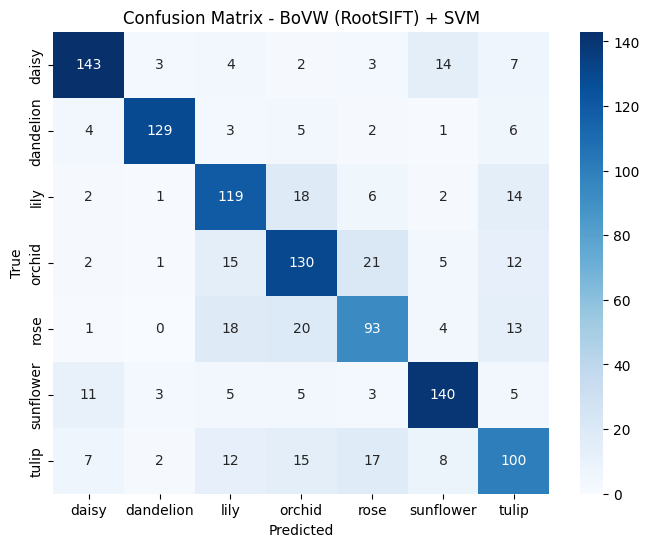

In [11]:
test_pred = svm_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, test_pred)

print("\n" + "="*50)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*50)
print("Test accuracy:", test_acc)
print("\nClassification report:")
print(classification_report(y_test, test_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BoVW (RootSIFT) + SVM")
plt.show()


Finding correct and incorrect predictions...
Total correct: 854
Total incorrect: 302

3 ẢNH DỰ ĐOÁN ĐÚNG


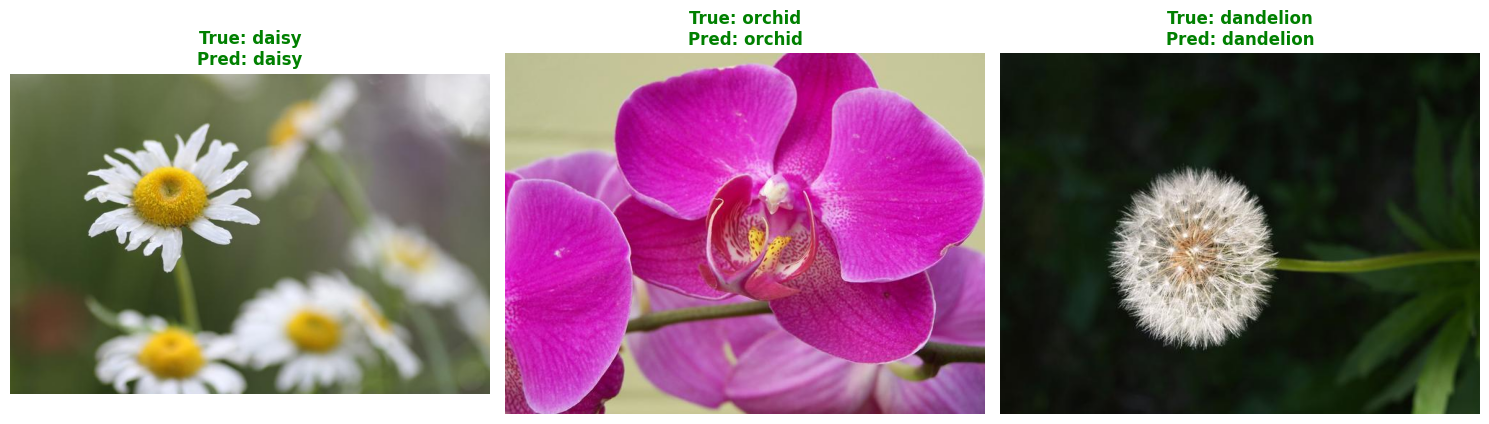


3 ẢNH DỰ ĐOÁN SAI


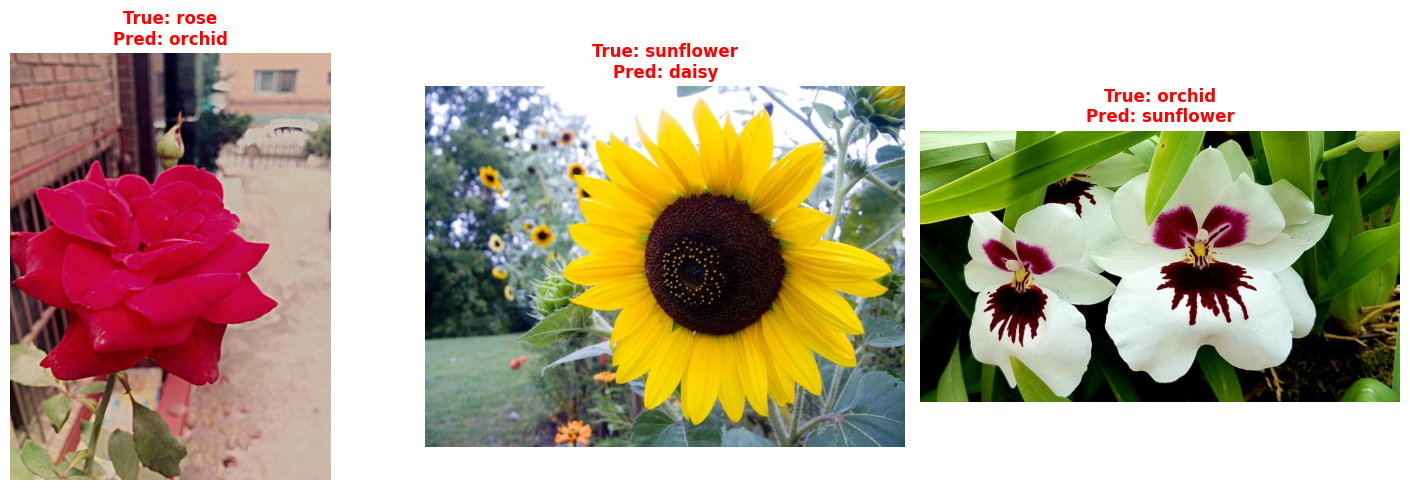

In [12]:
# ============================================
# Hiển thị ảnh dự đoán đúng và sai
# ============================================

print("\n" + "="*50)
print("Finding correct and incorrect predictions...")
print("="*50)

# Lấy danh sách tất cả ảnh test
test_images = []
for label, cls in enumerate(class_names):
    cls_dir = test_dir / cls
    img_files = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        img_files.extend(cls_dir.glob(ext))
    
    for img_path in img_files:
        test_images.append((img_path, label))

# Dự đoán và phân loại
correct_predictions = []
incorrect_predictions = []

for img_path, true_label in test_images:
    feats = image_to_bovw(img_path)
    feats = feats.reshape(1, -1)
    feats_scaled = scaler.transform(feats)
    feats_pca = pca.transform(feats_scaled)
    pred_label = svm_final.predict(feats_pca)[0]
    
    if pred_label == true_label:
        correct_predictions.append((img_path, true_label, pred_label))
    else:
        incorrect_predictions.append((img_path, true_label, pred_label))

print(f"Total correct: {len(correct_predictions)}")
print(f"Total incorrect: {len(incorrect_predictions)}")

# Hiển thị 3 ảnh dự đoán đúng
if len(correct_predictions) >= 3:
    print("\n" + "="*50)
    print("3 ẢNH DỰ ĐOÁN ĐÚNG")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    np.random.seed(42)
    sample_correct = np.random.choice(len(correct_predictions), 3, replace=False)
    
    for idx, sample_idx in enumerate(sample_correct):
        img_path, true_label, pred_label = correct_predictions[sample_idx]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                           color='green', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị 3 ảnh dự đoán sai
if len(incorrect_predictions) >= 3:
    print("\n" + "="*50)
    print("3 ẢNH DỰ ĐOÁN SAI")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    np.random.seed(42)
    sample_incorrect = np.random.choice(len(incorrect_predictions), 3, replace=False)
    
    for idx, sample_idx in enumerate(sample_incorrect):
        img_path, true_label, pred_label = incorrect_predictions[sample_idx]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                           color='red', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Lưu model

In [13]:
model_data = {
    "kmeans": kmeans,           # Để tạo BoVW từ SIFT
    "scaler": scaler,           # Để chuẩn hóa dữ liệu
    "pca": pca,                 # Để giảm chiều dữ liệu
    "model": svm_final,         # Model SVM cuối cùng
    "class_names": class_names, # Danh sách tên các loài hoa
    "K_value": K                # Số lượng cụm K (700)
}

filename = "bovw_only_svm.pkl"
with open(filename, "wb") as f:
    pickle.dump(model_data, f)

print("\n" + "="*50)
print(f"✅ Đã lưu xong file: {filename}")
print("="*50)


✅ Đã lưu xong file: bovw_only_svm.pkl
